<a href="https://colab.research.google.com/github/JohnPoma/Lung_cancer_projet/blob/main/Lung_col_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# code pour monter drive dans colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# afficher le nombre de données par repertoires du dossier principal

import os

# Replace '/content/drive/MyDrive' with the actual path to your main directory
main_directory = '/content/drive/My Drive/Deeplearning/lung_image_sets'

for root, dirs, files in os.walk(main_directory):
  print(f"Directory: {root}, Number of files: {len(files)}")

Directory: /content/drive/My Drive/Deeplearning/lung_image_sets, Number of files: 1
Directory: /content/drive/My Drive/Deeplearning/lung_image_sets/lung_n, Number of files: 5000
Directory: /content/drive/My Drive/Deeplearning/lung_image_sets/lung_aca, Number of files: 5000
Directory: /content/drive/My Drive/Deeplearning/lung_image_sets/lung_scc, Number of files: 5000
Directory: /content/drive/My Drive/Deeplearning/lung_image_sets/colon_aca, Number of files: 5000
Directory: /content/drive/My Drive/Deeplearning/lung_image_sets/colon_n, Number of files: 5000


In [4]:
# prompt: applique la data augmentation sur les données d'entrainement

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemin vers le répertoire contenant les données d'entraînement
train_data_dir = '/content/drive/My Drive/Deeplearning/split_lun_col/train'
test_dataset_path = '/content/drive/My Drive/Deeplearning/split_lun_col/test'
val_dataset_path = '/content/drive/My Drive/Deeplearning/split_lun_col/val'

# Créer un générateur d'augmentation de données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Appliquer l'augmentation de données sur les données d'entraînement
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # You might want to apply the same preprocessing as training data

val_generator = val_datagen.flow_from_directory(
    val_dataset_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    shuffle=False,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # You might want to apply the same preprocessing as training data

test_generator = test_datagen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed,
    shuffle=False,
    class_mode='categorical'
)

Found 17500 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.


In [5]:
#from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Charger MobileNet avec les poids pré-entraînés d'ImageNet sans la couche de sortie
#base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajout de la couche GlobalAveragePooling2D pour combiner les features
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Ajouter la dernière couche de classification pour 3 classes
output_layer = Dense(5, activation='softmax')(x)

# Créer un nouveau modèle
model = Model(inputs=base_model.input, outputs=output_layer)

# Geler les couches de base de MobileNet pour ne pas les entraîner
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks pour stopper l'entraînement tôt si la validation stagne et pour réduire le LR
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


547/547 ━━━━━━━━━━━━━━━━━━━━ 6152s 11s/step - accuracy: 0.4069 - loss: 1.4218 - val_accuracy: 0.7440 - val_loss: 0.7241 - learning_rate: 1.0000e-04
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 411s 644ms/step - accuracy: 0.7916 - loss: 0.6503 - val_accuracy: 0.8563 - val_loss: 0.4663 - learning_rate: 1.0000e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 400s 678ms/step - accuracy: 0.8542 - loss: 0.4692 - val_accuracy: 0.8731 - val_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 364s 644ms/step - accuracy: 0.8875 - loss: 0.3584 - val_accuracy: 0.8987 - val_loss: 0.3121 - learning_rate: 1.0000e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 385s 648ms/step - accuracy: 0.8993 - loss: 0.3200 - val_accuracy: 0.9139 - val_loss: 0.2731 - learning_rate: 1.0000e-04
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 383s 651ms/step - accuracy: 0.9096 - loss: 0.2850 - val_accuracy: 0.9168 - val_loss: 0.2539 - learning_rate: 1.0000e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 360s 648ms/s

In [8]:
# affiche le train et loss accuacy,test et loss accuracy,validation et loss accuracy

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.1260
Test Accuracy: 0.9584


In [9]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Train Loss: 0.1528
Train Accuracy: 0.9477
Validation Loss: 0.1246
Validation Accuracy: 0.9584


118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 237ms/step
              precision    recall  f1-score   support

   colon_aca       0.96      0.99      0.97       750
     colon_n       0.99      0.99      0.99       750
    lung_aca       0.94      0.89      0.91       750
      lung_n       0.99      0.99      0.99       750
    lung_scc       0.92      0.94      0.93       750

    accuracy                           0.96      3750
   macro avg       0.96      0.96      0.96      3750
weighted avg       0.96      0.96      0.96      3750



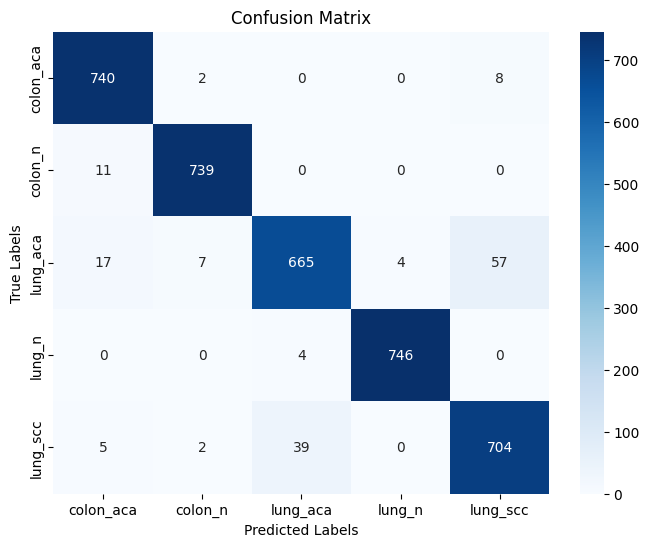

In [10]:
# prompt: matrice de confusion et le rapport de clasification

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the model
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Print the classification report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(true_classes, y_pred, target_names=class_labels))


# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

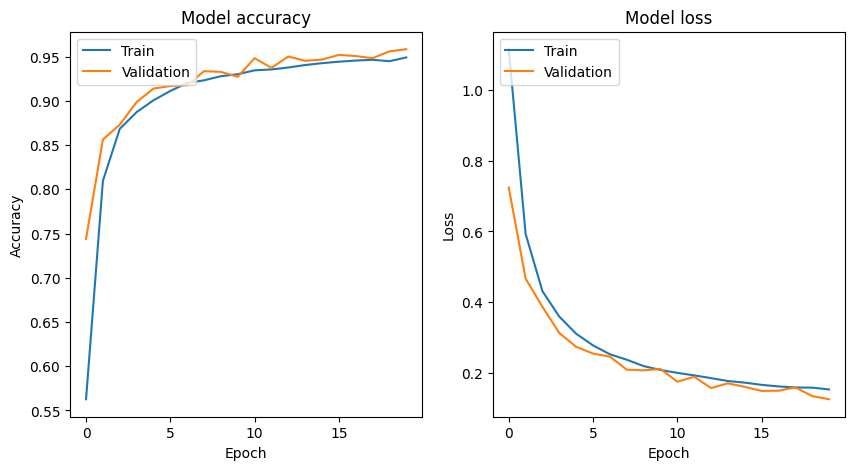

In [11]:
# prompt: afficher la courbe de validation et de perte
#from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
#  calculer AUC,F1-score,sensitivity,precision du modele. Global pour tout le modele
# calculer AUC,F1-score,sensitivity,precision du modele. Global pour tout le modele

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# ... (Your existing code) ...

# Get predictions from the model
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

# Calculate global AUC, F1-score, sensitivity, and precision
# Use 'ovr' for multiclass and provide the full probability array
roc_auc = roc_auc_score(true_classes, Y_pred, multi_class='ovr', average='weighted')
f1 = f1_score(true_classes, y_pred, average='weighted')  # Use weighted average
sensitivity = recall_score(true_classes, y_pred, average='weighted')  # Sensitivity is recall
precision = precision_score(true_classes, y_pred, average='weighted')

print(f"Global AUC: {roc_auc:.4f}")
print(f"Global F1-score: {f1:.4f}")
print(f"Global Sensitivity: {sensitivity:.4f}")
print(f"Global Precision: {precision:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 208ms/step
Global AUC: 0.9968
Global F1-score: 0.9582
Global Sensitivity: 0.9584
Global Precision: 0.9584


118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 207ms/step


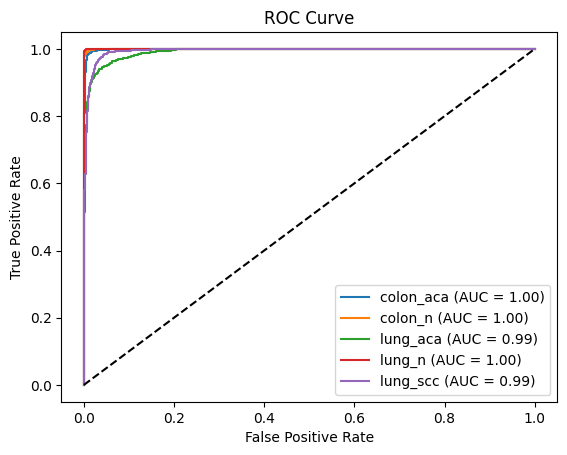

In [13]:
# prompt: ROC AUC

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
Y_pred_proba = model.predict(test_generator)

# Assuming you have 3 classes (e.g., 'normal', 'pneumonia', 'COVID-19')
# You can adjust the number of classes and labels accordingly
n_classes = 5
class_labels = list(test_generator.class_indices.keys())

# Calculate ROC AUC for each class
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(test_generator.classes == i, Y_pred_proba[:, i])
    auc = roc_auc_score(test_generator.classes == i, Y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()